Oh hey. Welcome to homework 2. We will learn to do some basic control of an old-school industrial robot.

https://en.wikipedia.org/wiki/Programmable_Universal_Machine_for_Assembly

For more details on this robot:

Corke, Peter. Robotics, vision and control: fundamental algorithms in MATLAB® second, completely revised. Vol. 118. Springer, 2017.

This is great resource on a wide range of robotics topics, with nice Matlab software associated with it. I have posted it on the canvas page.

Unfortunately, I did not have enough time to get nice visualizations working. However, Corke's book has lots of images of the robot, so you can pretend to see what is going on. 


In [1]:
import numpy as np
import scipy.integrate as itg
import scipy.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline

# The Basic Setup

The end of the robot typically holds a tool such as a gripper or screwrdriver. The goal of this assignment is to control the robot so that the tool makes  a desired swirling motion. Specifically, we want the position and angular orientation of the tool to follow a prescribed sequence. The combination of position and orientation is called the "pose". This is a special case of a tracking problem. 

As a bit of background, the pose is stored in a matrix of the form:
$$
T = \begin{bmatrix}
R & p \\
0 & 1
\end{bmatrix},
$$
where $R$ is a rotation matrix and $p$ is a position. This representation is helpful for calculations.

Some terminolgy:
* The problem of computing the tool pose from the joint angles is called  *forward kinematics*
* The problem of computing the angles that lead to a given tool pose is called the *inverse kinematics*


Now we will calculate the pose trajectory we want the system to follow.

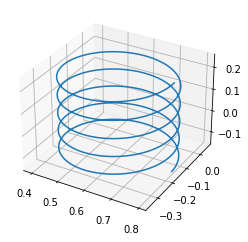

In [2]:
from puma560 import PUMA

robot = PUMA()

#  This is the initial collection of angles of the robot.
theta_neutral = np.pi * np.array([0,.25,1.,0,.25,0])

# The forward kinematics takes these joint angles
# And gives the "pose" of the tool.
T0 = robot.fkine(theta_neutral)
# The pose consists of a rotation matrix describing
# the orientation
R = T0[:3,:3]
# And a vector describing the position
px,py,pz = T0[:3,-1]


# This is the desired trajectory of tool positions:
Time = np.linspace(0,10,1000)
omega = np.pi
r = .2
dz = .4
P_seq = np.column_stack([px + r*np.cos(omega*Time),
                         py + r*np.sin(omega*Time),
                         py + dz * Time / Time[-1]])

ax = plt.axes(projection='3d')
ax.plot3D(P_seq[:,0],P_seq[:,1],P_seq[:,2])

# We actually want to find a sequence of poses
# For simplicity, we maintain a fixed orientation.
# This code just stuffs the positions into a sequence of poses
T_seq = np.array([np.block([[R,p.reshape((3,1))],
                            [np.zeros((1,3)),np.ones((1,1))]]) for p in P_seq])

# But Wait, There are Some Problems

One of the first challenges that arise with a robot of this type is that we don't control the pose directly. We use motors which apply torques to the joints to change their angles. A common way to approach this problem is to figure a sequence of angles that gives rise to the desired pose, and then control the joints to follow those angles. 

The problem of computing the desired angles is inverse kinematics. For each pose (position and orientation) of the tool, there are actually 8 different sets of joint angles that would reach it. In other words, the inverse kinematics problem has multiple solutions. If we just an arbitrary solution, it might jump around wildly as we change the pose. (Think about how many different ways you can reach something with your hands.)

In [3]:
# This is the first pose in the desired sequence
T = T_seq[0]
# To get the 10th pose, we could use T_seq[9]

# This is the inverse kinematics function
Thetas = robot.ikine(T)
# It gives an array of 8 different angle vectors
# such that all map to the same pose, T
for theta in Thetas:
    # Test it by checking that the angles indeed map to the pose
    # via forward  kinematics
    T_test = robot.fkine(theta)
    print(la.norm(T-T_test))

5.412488519334187e-16
3.9690927110819763e-16
2.630170674367309e-16
3.6616789818248407e-16
7.879914276205808e-16
7.957175793136646e-16
5.488408727228528e-16
7.981603815658341e-16


# Coding Question

Make a sequence of angles `Theta_seq[0]`,`Theta_seq[1]`,... such that
* `Theta_seq[0]` is the inverse kinematics solution (i.e. a set of angles which map to `T_seq[0]`) which is closest to `theta_neutral` with respect to the Euclidean norm.
* For `i >= 1`, `Theta_seq[i]` is the inverse kinematics solution for `T_seq[i]` which is closest to `Theta_seq[i-1]` with respect to the Euclidean norm.

Plot your angle trajectories with respect to time.

In [4]:
# Make your code here

# Classical Mechanics and Robot Dynamics

By now, we should have a good sequence of angles to follow, which give rise to the desired tool motion. But we do not set angles directly, we apply torques via the motors. To figure out how to do that, we must understand the dynamics.

Like most robotic manipulators, this robot has dynamics of the form:

\begin{align*}
\dot \theta(t) &= \omega(t) \\
M(\theta(t)) \dot\omega(t) + C(\theta(t),\omega(t))\omega(t) + D\omega(t) + G(\theta(t)) &= u(t)
\end{align*}

* $\theta(t)$ are generalized coordinates. In our example, they are the angles of the joints of the robot. In this case there are six joints, so $\theta(t)\in\mathbb{R}^6$.
* $\omega(t)$ are the associated velocities of these coordinates. In this case, $\omega(t)\in\mathbb{R}^6$.
* $M(\theta)$ is called the mass matrix. It is symmetric and positive definite. In this case, it is $6\times 6$.
* $C(\theta,\omega)$ is called the coriolis matrix. It is also $6\times 6$.
* $D$ is a positive definite damping matrix. It is constant for simplicity.
* $G(\theta)$ captures of the effects of gravity. 
* $u(t)$ are the torques that are input into the joints by the motors.

The state of the system is given by
\begin{equation*}
x(t) = \begin{bmatrix}
\theta(t)\\
\omega(t)
\end{bmatrix}
\end{equation*}

# Theory Question


There are many ways to control this system. We will examine a common, and successful approach to nonlinear controls, known as feedback linearization. While there are many variations of feedback linearization, one method is to simply cancel out all of the nonlinear terms. 

In this problem, $M(\theta)^{-1}$, $C(\theta,\omega)\omega$, and $G(\theta)$ are all nonlinear. Find a way of choosing $u(t)$ so that the dynamics take the form:
\begin{equation*}
\begin{bmatrix}
\dot \theta(t) \\
\dot \omega(t)
\end{bmatrix} = \begin{bmatrix}
\omega(t) \\
a(t)
\end{bmatrix}.
\end{equation*}

Here, $a(t)$ is an angular acceleration input that we choose. (So, this will be included in your choice of $u(t)$).

Either write your solution here or upload a hand-written document

# Coding Question

Use LQR to design a stabilizing feedback gain, $K$ for the feedback linearized system. Control your system using inputs of the form:
\begin{equation*}
a(t) = K\begin{bmatrix}
\theta(t)-\theta_{\mathrm{seq}}(t) \\
\omega(t)
\end{bmatrix}
\end{equation*}

Make two different plots:
* One plot should show how well you track the angles. Use subplots so the different angles can be distinguished.
* Another plot should should how well you track the tool position

Notes:
* Recall that the trajectory corresponds to the time sequence `Time = np.linspace(0,10,1000)`
* Don't worry about simulating the whole robot for now. Just simulate the linear system.
* Euler integration should suffice for this. (To use something like `scipy.integrate` you would need to make an interpolation of the desired angles over time.)
* You may need  to tune $Q$ and $R$ to get good tracking

In [6]:
# Make your code here

# Theory Question

The kinetic energy of the system is given by:
\begin{equation*}
KE(\theta,\omega) = \frac{1}{2}\omega^\top M(\theta) \omega
\end{equation*}
The potential energy is given by $PE(\theta) = U(\theta)$, where $U$ is a function such that $\nabla_{\theta} U(\theta) = G(\theta)$. 

The total energy  is given by:
$$V(\theta,\omega) = KE(\theta,\omega)+PE(\theta) = \frac{1}{2}\omega^\top M(\theta) \omega + U(\theta(t))$$

It can be shown that the entries of $C(\theta,\omega)$ are given by:
\begin{equation*}
C_{ij}(\theta,\omega) = \sum_{k=1}^6 \left(\frac{\partial M_{ij}(\theta)}{\partial \theta_k} - \frac{1}{2}\frac{\partial M_{kj}(\theta)}{\partial \theta_i} \right)\omega_k
\end{equation*}

Show that if $\theta(t)$ and $\omega(t)$ are defined by the dynamics above, with $u(t)=0$ for all $t$, then 
$$
\frac{d}{dt} V(\theta(t),\omega(t)) = -\omega(t)^\top D \omega(t).
$$

Either write your solution here, or upload a hand-written document.

# Discussion

Assuming that $U$ is bounded below, 
this result suffices to prove that almost trajectories will converge to states of the form $x_{eq} = \begin{bmatrix}
\theta^\star \\
0
\end{bmatrix}$,
where $\theta^*$ is a local minimum of the potential energy. While it is not a big leap beyond what we will do in class, we will not prove it explicitly.

I was hoping to do some fun stuff with this idea for this homework, but it will have to wait till the next assignment.
